In [1]:
import requests, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
SESSION = requests.Session()
f = open("../bs_node_ip.txt","r")
RPC_HOST = f.readline()
RPC_HOST = str.replace(RPC_HOST,'\n','')
RPC_PORT = '8545'
RPC_URL = 'http://'+RPC_HOST+':'+RPC_PORT
pd.set_option('max_colwidth', 70)

## Basic JSON downloading

In [2]:
def getJSON(url, d=None):
    h = {"Content-Type": "application/json"}
    if d is None:
        r = SESSION.get(url, headers=h)
    else:
        r = SESSION.post(url, data=d, headers=h)
    json_data = r.text
    response = json.loads(json_data)
    return response

In [3]:
def getRawJSON(url, d=None):
    h = {"Content-Type": "application/json"}
    if d is None:
        r = SESSION.get(url, headers=h)
    else:
        r = SESSION.post(url, data=d, headers=h)
    json_data = r.text
    return json_data

In [4]:
# test if the getJSON function supports GET requests
# getJSON('https://api.etherscan.io/api?module=account&action=balance&address=0xde0b295669a9fd93d5f28d9ec85e40f4cb697bae&tag=latest&apikey=YourApiKeyToken')

In [5]:
# test if the getJSON function supports POST requests
# getJSON(RPC_URL,'{"jsonrpc":"2.0","method":"eth_syncing","params":[],"id":1}')

## Consensys EthJsonRpc Package

I wasn't able to quickly make the package work on Python 3

In [6]:
# from ethjsonrpc import EthJsonRpc
# c = EthJsonRpc('35.196.250.157', 8545)
# print(c.net_version())
# print(c.web3_clientVersion())
# print(c.eth_gasPrice())

So I began copying their functions. Most of them still need testing. Ideally we should fork and make our own package compatible with Python 3

In [7]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def hex_to_dec(x):
    '''
    Convert hex to decimal
    '''
    return int(x, 16)

In [8]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def clean_hex(d):
    '''
    Convert decimal to hex and remove the "L" suffix that is appended to large
    numbers
    '''
    return hex(d).rstrip('L')

In [9]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def validate_block(block):
#     doesn't work on Python 3
#     if isinstance(block, basestring):
#         if block not in BLOCK_TAGS:
#             raise ValueError('invalid block tag')
    if isinstance(block, int):
        block = hex(block)
    return block

In [10]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def wei_to_ether(wei):
    '''
    Convert wei to ether
    '''
    return 1.0 * wei / 10**18

In [11]:
# FROM https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/utils.py
def ether_to_wei(ether):
    '''
    Convert ether to wei
    '''
    return ether * 10**18

In [12]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/exceptions.py
class EthJsonRpcError(Exception):
    pass
class ConnectionError(EthJsonRpcError):
    pass
class BadStatusCodeError(EthJsonRpcError):
    pass
class BadJsonError(EthJsonRpcError):
    pass
class BadResponseError(EthJsonRpcError):
    pass

In [13]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
BLOCK_TAG_EARLIEST = 'earliest'
BLOCK_TAG_LATEST   = 'latest'
BLOCK_TAG_PENDING  = 'pending'
BLOCK_TAGS = (
    BLOCK_TAG_EARLIEST,
    BLOCK_TAG_LATEST,
    BLOCK_TAG_PENDING,
)

In [14]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def _call(method, params=None, _id=1):
    params = params or []
    data = {
        'jsonrpc': '2.0',
        'method':  method,
        'params':  params,
        'id':      _id,
    }
    scheme = 'http'
#     if tls:
#         scheme += 's'
    url = '{}://{}:{}'.format(scheme, RPC_HOST, RPC_PORT)
    headers = {'Content-Type': 'application/json'}
    try:
        r = SESSION.post(url, headers=headers, data=json.dumps(data))
    except RequestsConnectionError:
        raise ConnectionError
    if r.status_code / 100 != 2:
        raise BadStatusCodeError(r.status_code)
    try:
        response = r.json()
    except ValueError:
        raise BadJsonError(r.text)
    try:
        return response['result']
    except KeyError:
        raise BadResponseError(response)

In [15]:
################################################################################
# JSON-RPC methods
################################################################################

In [16]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def web3_sha3(data):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#web3_sha3
    NEEDS TESTING
    '''
    data = str(data).encode('hex')
    return _call('web3_sha3', [data])

In [17]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_call(to_address, from_address=None, gas=None, gas_price=None, value=None, data=None,
             default_block=BLOCK_TAG_LATEST):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_call
    NEEDS TESTING
    '''
#     doesn't work on Python 3
#     if isinstance(default_block, basestring):
#         if default_block not in BLOCK_TAGS:
#             raise ValueError
    obj = {}
    obj['to'] = to_address
    if from_address is not None:
        obj['from'] = from_address
    if gas is not None:
        obj['gas'] = hex(gas)
    if gas_price is not None:
        obj['gasPrice'] = clean_hex(gas_price)
    if value is not None:
        obj['value'] = value
    if data is not None:
        obj['data'] = data
    return _call('eth_call', [obj, default_block])

In [18]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockByHash(block_hash, tx_objects=True):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblockbyhash
    NEEDS TESTING
    '''
    return _call('eth_getBlockByHash', [block_hash, tx_objects])

In [19]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getBlockByNumber(block=BLOCK_TAG_LATEST, tx_objects=True):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getblockbynumber
    NEEDS TESTING
    '''
    block = validate_block(block)
    return _call('eth_getBlockByNumber', [block, tx_objects])

In [20]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionByHash(tx_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionbyhash
    NEEDS TESTING
    '''
    return _call('eth_getTransactionByHash', [tx_hash])

In [21]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_getTransactionReceipt(tx_hash):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_gettransactionreceipt
    NEEDS TESTING
    '''
    return _call('eth_getTransactionReceipt', [tx_hash])

In [22]:
#FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
#def eth_getLogs(filter_object):
#    return _call('eth_getLogs', [filter_object])

# redefined by Markus 2018-02-08
def eth_getLogs(from_block=BLOCK_TAG_LATEST, to_block=BLOCK_TAG_LATEST, address=None, topics=None):
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_getlogs
    TESTED - MARKUS 2018-02-08
    '''
    _filter = {
        'fromBlock': from_block,
        'toBlock':   to_block,
        'address':   address,
        'topics':    topics,
    }
    return _call('eth_getLogs', [_filter])

In [23]:
# FROM: https://github.com/ConsenSys/ethjsonrpc/blob/master/ethjsonrpc/client.py
def eth_blockNumber():
    '''
    https://github.com/ethereum/wiki/wiki/JSON-RPC#eth_blocknumber
    TESTED - MARKUS 2018-02-07
    '''
    return hex_to_dec(_call('eth_blockNumber'))

In [51]:
import warnings
warnings.filterwarnings('ignore')

# Crypto Kitties Explorer
Exploring CryptoKitties data using JSON RPC on the BlockScience geth node

There are 3 accounts we're interested in
1. Core game smart-contract
1. Siring auction smart-contract, where players "rent" their cats for other players to breed their cats with
1. Sale auction smart-contract, where players sell their cats

In [24]:
# define the addresses of the relevant contracts
coreContract = '0x06012c8cf97bead5deae237070f9587f8e7a266d'
contracts = {
    coreContract : 'core',
    '0xc7af99fe5513eb6710e6d5f44f9989da40f27f26' : 'siringAuction',
    '0xb1690c08e213a35ed9bab7b318de14420fb57d8c' : 'saleAuction',
}

Some of the things (_events_) that happen during the game are logged on the blockchain, such as an auction being created or a cat getting pregnant

In [25]:
# relevant Events signatures
events_signatures = {
    'AuctionCreated' : 'AuctionCreated(uint256,uint256,uint256,uint256)', # AuctionCreated(uint256 tokenId, uint256 startingPrice, uint256 endingPrice, uint256 duration);
    'AuctionSuccessful' : 'AuctionSuccessful(uint256,uint256,address)', # AuctionSuccessful(uint256 tokenId, uint256 totalPrice, address winner);
    'AuctionCancelled' : 'AuctionCancelled(uint256)', # AuctionCancelled(uint256 tokenId);
    'Pause' : 'Pause()',
    'Unpause' : 'Unpause()',
    'Transfer' : 'Transfer(address,address,uint256)', # Transfer(address from, address to, uint256 tokenId);
    'Approval' : 'Approval(address,address,uint256)', # Approval(address owner, address approved, uint256 tokenId);
    'ContractUpgrade' : 'ContractUpgrade(address)',
    'Birth' : 'Birth(address,uint256,uint256,uint256,uint256)', # Birth(address owner, uint256 kittyId, uint256 matronId, uint256 sireId, uint256 genes);
    'Pregnant' : 'Pregnant(address,uint256,uint256,uint256)' # Pregnant(address owner, uint256 matronId, uint256 sireId, uint256 cooldownEndBlock);
}

from Crypto.Hash import keccak
def keccak256(string):
    return keccak.new(digest_bits=256, data=bytes(string, 'utf-8')).hexdigest()

events_hashes = {'0x'+keccak256(v): k for k, v in events_signatures.items()}
for event in events_signatures:
    print(event + ': ' + keccak256(events_signatures[event]))

AuctionCreated: a9c8dfcda5664a5a124c713e386da27de87432d5b668e79458501eb296389ba7
AuctionSuccessful: 4fcc30d90a842164dd58501ab874a101a3749c3d4747139cefe7c876f4ccebd2
AuctionCancelled: 2809c7e17bf978fbc7194c0a694b638c4215e9140cacc6c38ca36010b45697df
Pause: 6985a02210a168e66602d3235cb6db0e70f92b3ba4d376a33c0f3d9434bff625
Unpause: 7805862f689e2f13df9f062ff482ad3ad112aca9e0847911ed832e158c525b33
Transfer: ddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef
Approval: 8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925
ContractUpgrade: 450db8da6efbe9c22f2347f7c2021231df1fc58d3ae9a2fa75d39fa446199305
Birth: 0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5
Pregnant: 241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80


Because we know the events signatures, we can query the blockchain for all the transactions that caused those events to happen

In [26]:
def getEvents(_address, _from_block, _to_block):
    json = eth_getLogs(from_block=_from_block, 
                       to_block=_to_block,
                       address=_address)
    df = pd.DataFrame.from_dict(json)
    df['contract'] = df['address'].apply(lambda x: contracts[x])
    df['event'] = df['topics'].apply(lambda x: events_hashes[x[0]])
    return df

from_block = hex(eth_blockNumber() - 10000)
to_block = hex(eth_blockNumber())

events = None

for c in contracts:
    if events is None:
        events = getEvents(c, from_block, to_block)
    else:
        e = getEvents(c, from_block, to_block)
        events = events.append(e, ignore_index=True)
events['blockNumber_dec'] = events['blockNumber'].apply(lambda x: int(x,16))
events.head()

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,contract,event,blockNumber_dec
0,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x3945f5094756d8988618ebbc7f00e571850fdd0c10fa50ac2a713ef41cdcaab0,0x51308e,0x000000000000000000000000bc1b89612b8c8e006929197569818e785e427bfb...,0x1,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0x776273f9a7f6ed0242d50c3c0b4fe01d80bbf4cd2a051085f17fdb7f79003b30,0x7,core,Birth,5320846
1,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x3945f5094756d8988618ebbc7f00e571850fdd0c10fa50ac2a713ef41cdcaab0,0x51308e,0x0000000000000000000000000000000000000000000000000000000000000000...,0x2,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef],0x776273f9a7f6ed0242d50c3c0b4fe01d80bbf4cd2a051085f17fdb7f79003b30,0x7,core,Transfer,5320846
2,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x3945f5094756d8988618ebbc7f00e571850fdd0c10fa50ac2a713ef41cdcaab0,0x51308e,0x0000000000000000000000000de69b30c7c2fe14276dda312f4de3231dfa34f8...,0x5,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0x24ba2044a72bdbbc627a232f10751728e9a1c16b0a53f3ab7263c7e577d5c0b3,0xc,core,Birth,5320846
3,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x3945f5094756d8988618ebbc7f00e571850fdd0c10fa50ac2a713ef41cdcaab0,0x51308e,0x0000000000000000000000000000000000000000000000000000000000000000...,0x6,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef],0x24ba2044a72bdbbc627a232f10751728e9a1c16b0a53f3ab7263c7e577d5c0b3,0xc,core,Transfer,5320846
4,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x3945f5094756d8988618ebbc7f00e571850fdd0c10fa50ac2a713ef41cdcaab0,0x51308e,0x000000000000000000000000bc1b89612b8c8e006929197569818e785e427bfb...,0x8,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0xa03a4b82e54dfc624577b24c60153563e278cc100916082cda5bd8ac7961687c,0x13,core,Pregnant,5320846


As expected, the core game smart-contract is reponsible for logging the births, pregnancies, transfers and approvals of kitties. The auctioning smart-contracts log events referring to creation, completion and cancellation of auctions.

In [27]:
events[['contract','event']].drop_duplicates()

,contract,event
0,core,Birth
1,core,Transfer
4,core,Pregnant
3328,core,Approval
13775,siringAuction,AuctionSuccessful
13777,siringAuction,AuctionCreated
13797,siringAuction,AuctionCancelled
15334,saleAuction,AuctionCreated
15335,saleAuction,AuctionCancelled
15336,saleAuction,AuctionSuccessful


Pie chart analysis
1. The Pregnant event is a lot more frequent than the AuctionSuccessful event by the siring auction smart-contract. Bcause every successful siring auction results in a pregancy, this means that most breeding is being done between cats that belong to the same player.
1. The transfer event is a lot more frequent than the AuctionSuccessful event by the sale auction smart-contract. Because every successful sale auction results in a transfer, this means that most transfers are being done via some other mechanism, such as people transfering cats between two accounts they own, giving cats away, or maybe there is some other cheaper decentralized kitty exchange?

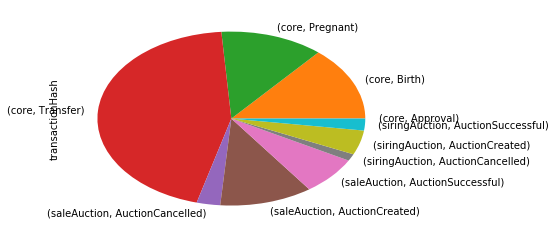

In [28]:
events.groupby(['contract','event']).transactionHash.count().plot(kind='pie')

Bar chart gives us an idea of volume: roughly one pregancy and one birth per block; 2-3 transfers per block

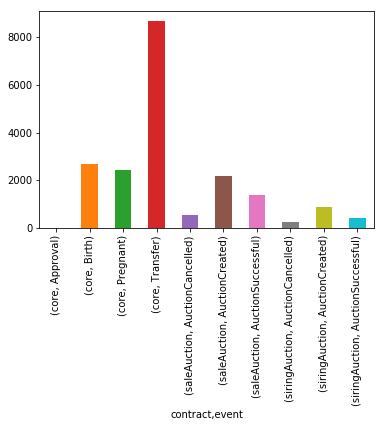

In [29]:
events.groupby(['contract','event']).transactionHash.count().plot(kind='bar')

Based on my understanding of the game dynamics, I expected every transaction to cause one event to happen, or at most two in case of a successful siring or sale auction, which would be followed by a pregnancy or a transfer.
But when we group the events by the transaction that caused them to happen, we see sometimes a single transaction causes more than on event to happen, eg 0x21e6760d4cb24918c1d0d2722674e2fae90acf64516b27cc233446909e6c1a6e

In [30]:
events.sort_values(['blockNumber', 'transactionIndex', 'logIndex']).head(20)

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,contract,event,blockNumber_dec
4,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x3945f5094756d8988618ebbc7f00e571850fdd0c10fa50ac2a713ef41cdcaab0,0x51308e,0x000000000000000000000000bc1b89612b8c8e006929197569818e785e427bfb...,0x8,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0xa03a4b82e54dfc624577b24c60153563e278cc100916082cda5bd8ac7961687c,0x13,core,Pregnant,5320846
5,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x3945f5094756d8988618ebbc7f00e571850fdd0c10fa50ac2a713ef41cdcaab0,0x51308e,0x0000000000000000000000009c6c1eab0f439db9cfd103b53d99f4e6c63542d4...,0xc,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef],0x9a5f0b594aef41e856fb44fa985a36cd48a07d1f159ac739c573d9844c9351b9,0x1a,core,Transfer,5320846
15334,0xb1690c08e213a35ed9bab7b318de14420fb57d8c,0x3945f5094756d8988618ebbc7f00e571850fdd0c10fa50ac2a713ef41cdcaab0,0x51308e,0x000000000000000000000000000000000000000000000000000000000009d7be...,0xd,False,[0xa9c8dfcda5664a5a124c713e386da27de87432d5b668e79458501eb296389ba7],0x9a5f0b594aef41e856fb44fa985a36cd48a07d1f159ac739c573d9844c9351b9,0x1a,saleAuction,AuctionCreated,5320846
13775,0xc7af99fe5513eb6710e6d5f44f9989da40f27f26,0x3945f5094756d8988618ebbc7f00e571850fdd0c10fa50ac2a713ef41cdcaab0,0x51308e,0x0000000000000000000000000000000000000000000000000000000000099a1b...,0x39,False,[0x4fcc30d90a842164dd58501ab874a101a3749c3d4747139cefe7c876f4ccebd2],0x956b15a3523ffb6f64dbe79df2d0ca817330223b41f1d65f50a393c1daceccc9,0x3f,siringAuction,AuctionSuccessful,5320846
6,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x3945f5094756d8988618ebbc7f00e571850fdd0c10fa50ac2a713ef41cdcaab0,0x51308e,0x000000000000000000000000c7af99fe5513eb6710e6d5f44f9989da40f27f26...,0x3a,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef],0x956b15a3523ffb6f64dbe79df2d0ca817330223b41f1d65f50a393c1daceccc9,0x3f,core,Transfer,5320846
7,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x3945f5094756d8988618ebbc7f00e571850fdd0c10fa50ac2a713ef41cdcaab0,0x51308e,0x000000000000000000000000447331e3e8e1d9fd2878e345c7fe11c88db0858f...,0x3b,False,[0x241ea03ca20251805084d27d4440371c34a0b85ff108f6bb5611248f73818b80],0x956b15a3523ffb6f64dbe79df2d0ca817330223b41f1d65f50a393c1daceccc9,0x3f,core,Pregnant,5320846
0,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x3945f5094756d8988618ebbc7f00e571850fdd0c10fa50ac2a713ef41cdcaab0,0x51308e,0x000000000000000000000000bc1b89612b8c8e006929197569818e785e427bfb...,0x1,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0x776273f9a7f6ed0242d50c3c0b4fe01d80bbf4cd2a051085f17fdb7f79003b30,0x7,core,Birth,5320846
1,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x3945f5094756d8988618ebbc7f00e571850fdd0c10fa50ac2a713ef41cdcaab0,0x51308e,0x0000000000000000000000000000000000000000000000000000000000000000...,0x2,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef],0x776273f9a7f6ed0242d50c3c0b4fe01d80bbf4cd2a051085f17fdb7f79003b30,0x7,core,Transfer,5320846
2,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x3945f5094756d8988618ebbc7f00e571850fdd0c10fa50ac2a713ef41cdcaab0,0x51308e,0x0000000000000000000000000de69b30c7c2fe14276dda312f4de3231dfa34f8...,0x5,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0x24ba2044a72bdbbc627a232f10751728e9a1c16b0a53f3ab7263c7e577d5c0b3,0xc,core,Birth,5320846
3,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x3945f5094756d8988618ebbc7f00e571850fdd0c10fa50ac2a713ef41cdcaab0,0x51308e,0x0000000000000000000000000000000000000000000000000000000000000000...,0x6,False,[0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef],0x24ba2044a72bdbbc627a232f10751728e9a1c16b0a53f3ab7263c7e577d5c0b3,0xc,core,Transfer,5320846


### Who is calling giveBirth?

Let's take a deeper look at the Birth events

In [52]:
births = events[events['event'] == 'Birth']
births['owner'] = '0x' + births['data'].apply(lambda x: x[26:66])
births['kittyId'] = births['data'].apply(lambda x: x[66:130])
births['kittyId_dec'] = births['kittyId'].apply(lambda x: int(x,16))
births['matronId'] = births['data'].apply(lambda x: x[130:194])
births['matronId_dec'] = births['matronId'].apply(lambda x: int(x,16))
births['sireId'] = births['data'].apply(lambda x: x[194:258])
births['sireId_dec'] = births['sireId'].apply(lambda x: int(x,16))
births['kittyGenes'] = births['data'].apply(lambda x: x[258:322])
births.head()

,address,blockHash,blockNumber,data,logIndex,removed,topics,transactionHash,transactionIndex,contract,event,blockNumber_dec,owner,kittyId,kittyId_dec,matronId,matronId_dec,sireId,sireId_dec,kittyGenes
0,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x3945f5094756d8988618ebbc7f00e571850fdd0c10fa50ac2a713ef41cdcaab0,0x51308e,0x000000000000000000000000bc1b89612b8c8e006929197569818e785e427bfb...,0x1,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0x776273f9a7f6ed0242d50c3c0b4fe01d80bbf4cd2a051085f17fdb7f79003b30,0x7,core,Birth,5320846,0xbc1b89612b8c8e006929197569818e785e427bfb,000000000000000000000000000000000000000000000000000000000009d9c6,645574,000000000000000000000000000000000000000000000000000000000009c305,639749,000000000000000000000000000000000000000000000000000000000009a46e,631918,000062d0b285b231826339ef294ac1b4202b44d700a5509b65bdeb08de128c63
2,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x3945f5094756d8988618ebbc7f00e571850fdd0c10fa50ac2a713ef41cdcaab0,0x51308e,0x0000000000000000000000000de69b30c7c2fe14276dda312f4de3231dfa34f8...,0x5,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0x24ba2044a72bdbbc627a232f10751728e9a1c16b0a53f3ab7263c7e577d5c0b3,0xc,core,Birth,5320846,0x0de69b30c7c2fe14276dda312f4de3231dfa34f8,000000000000000000000000000000000000000000000000000000000009d9c7,645575,000000000000000000000000000000000000000000000000000000000002f820,194592,00000000000000000000000000000000000000000000000000000000000827b7,534455,000062d2b310b248dce4a9c9394e514c533516e399456b4a631c234aaac7314b
10,0x06012c8cf97bead5deae237070f9587f8e7a266d,0x0b4a90f2cf1941da7b2550f5f983ff408f4d8df2f0dd31fab33fd755332ff652,0x513091,0x00000000000000000000000068b42e44079d1d0a4a037e8c6ecd62c48967e69f...,0x0,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0x2339ee63d0525491843cd8cd02d67d5828bf1b771c67f0fc0963649d44b0b997,0x7,core,Birth,5320849,0x68b42e44079d1d0a4a037e8c6ecd62c48967e69f,000000000000000000000000000000000000000000000000000000000009d9c8,645576,00000000000000000000000000000000000000000000000000000000000933a4,603044,00000000000000000000000000000000000000000000000000000000000950ac,610476,00007b16b098a4725c37a5222a4ac6014a589062bc0509cac181e82282119400
12,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xc9997805570ea92e0bf214370c39276acc9c8eaf9ff9a2cd88f72343fa412349,0x513092,0x000000000000000000000000442dccee68425828c106a3662014b4f131e3bd9b...,0x1,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0xafce02a986fd546a1ab32624c5072c12141f325c94dcb254d91f5019a747b94f,0x1,core,Birth,5320850,0x442dccee68425828c106a3662014b4f131e3bd9b,000000000000000000000000000000000000000000000000000000000009d9c9,645577,0000000000000000000000000000000000000000000000000000000000091113,594195,0000000000000000000000000000000000000000000000000000000000092e86,601734,00004228809133185c61a50010180098047210c7014069027399011b02c0842f
14,0x06012c8cf97bead5deae237070f9587f8e7a266d,0xc9997805570ea92e0bf214370c39276acc9c8eaf9ff9a2cd88f72343fa412349,0x513092,0x00000000000000000000000076ace81c8f7aae393ee2fcc1c3116cae79ac5722...,0x5,False,[0x0a5311bd2a6608f08a180df2ee7c5946819a649b204b554bb8e39825b2c50ad5],0x2924ffac3536b0547ead993287a3048ce085b2169b21bc80b007f5985488df12,0x10,core,Birth,5320850,0x76ace81c8f7aae393ee2fcc1c3116cae79ac5722,000000000000000000000000000000000000000000000000000000000009d9ca,645578,00000000000000000000000000000000000000000000000000000000000541f4,344564,0000000000000000000000000000000000000000000000000000000000033e1b,212507,00004a594290a672521729c900c0021084619cc28cc629ce638a2673d8c5258b


Most transactions only give birth to one cat; but some give birth to more

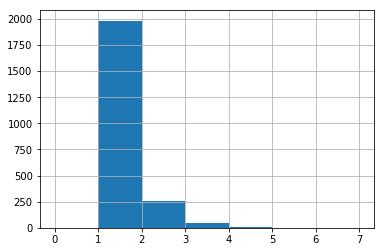

In [53]:
maxBirths = births.groupby(['transactionHash']).transactionHash.count().max()
births.groupby(['transactionHash']).transactionHash.count().hist(bins=range(maxBirths+2))

Let's get more information about the transactions that caused the births

In [54]:
births['transaction'] = births['transactionHash'].apply(lambda x: eth_getTransactionByHash(x))

In [55]:
births['transactionReceipt'] = births['transactionHash'].apply(lambda x: eth_getTransactionReceipt(x))

Who is making the transaction

In [56]:
births['caller'] = births['transaction'].apply(lambda x: x['from'])

What smart-contract are they sending the transaction to

In [57]:
births['called'] = births['transaction'].apply(lambda x: x['to'])

How much gas they are using

In [58]:
births['gas'] = births['transactionReceipt'].apply(lambda x: int(x['gasUsed'],16))

How much are they paying for gas

In [59]:
births['gasPrice'] = births['transaction'].apply(lambda x: int(x['gasPrice'],16))

How much that means in fees

In [60]:
births['fee'] = births['gas'] * births['gasPrice'] * 1E-18

A few accounts are responsible for most of the births

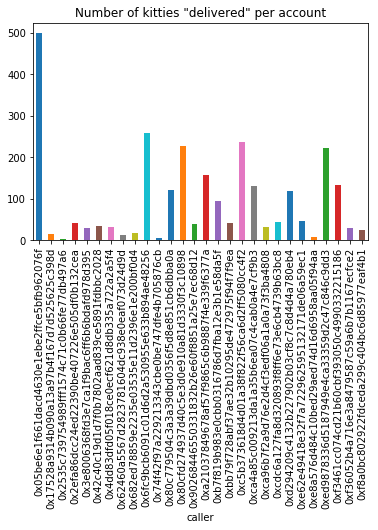

In [40]:
births.groupby(['caller']).data.count().plot(kind='bar', title='Number of kitties "delivered" per account')

And those accounts are not directly calling the giveBirth method on the core game smart-contract (0x06012...). Instead, they are sending transactions to other accounts. A quick look at those accounts on Etherscan shows us that those are smart-contracts. So people are calling intermediary smart-contracts that in turn call giveBirth on a series of pregnant kitties. There are less intermediary smart-contracts than accounts calling them, which leads us to believe that there are even less people doing this than the initial number of accounts would suggest (one person might be using several accounts to call their intermediary smart-contract, but there is not much point in a single person having several smart contracts)

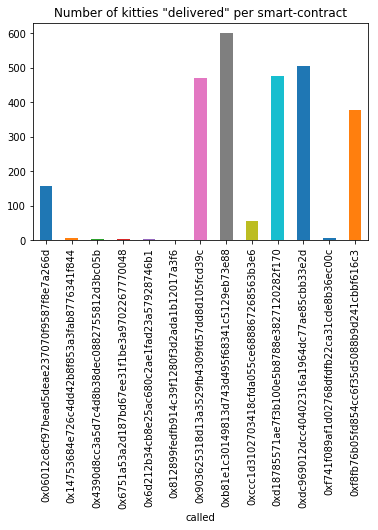

In [41]:
births.groupby(['called']).data.count().plot(kind='bar', title='Number of kitties "delivered" per smart-contract')

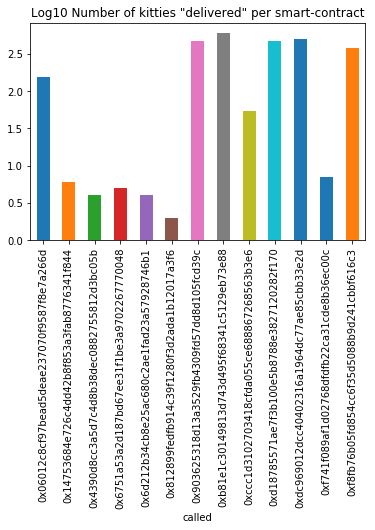

In [47]:
births.groupby(['called']).data.count().apply('log10').plot(kind='bar', title='Log10 Number of kitties "delivered" per smart-contract')

When you breed two cats, you must provide a birthing fee (0.008 ETH as of now), to be collected by the account that calls the giveBirth method on the matron cat at or after the block when the pregnancy ends. *Anyone* can call that method and thus collect the fee, but the new cat always goes to the owner of the matron.

I did not see the reasoning behind this fee, as it seemed to only make the game more expensive to be played. The giveBirth method could have been integrated into some other action of the game in such a way that the player would naturally call it whenever givingBirth suited their needs. Then I found [this](https://medium.com/cryptokitties/cryptokitties-birthing-fees-increases-in-order-to-accommodate-demand-acc314fcadf5):
>Because this giveBirth() function includes a random element, it is critical that it is called quickly after the expected birthing time (within 250 blocks, or about 30 minutes). If the call takes any longer, it provides the opportunity for bad actors to “re-roll” the random element of their genetic combination and gain an unfair advantage against other breeders. To keep this from happening, we allow anyone to call giveBirth() and we give the entire birthing fee to the first caller that successfully births the new kitten. This ensures that ... there is an incentive for other people in the community to ensure that all births are happening quickly.

So the game creates an incentive for people - who might not even be players of the game themselves - to call the giveBirth method on other people's pregnant cats. Sure enough, bots (smart-contracts) seem to have been coded to do just that.

How much money are the midwives doing. Assumes 0.008 ETH reward, but this value has varied in the past

In [42]:
count = pd.DataFrame(births.groupby(['transactionHash']).transactionHash.count())
fees = births.groupby(['transactionHash']).fee.max()
caller = births.groupby(['transactionHash']).caller.max()
called = births.groupby(['transactionHash']).called.max()
res = count.join(fees).join(caller).join(called)
res.columns = ['count','fee','caller','called']
res['profit'] = res['count'] * 0.008 - res['fee']
res['efficiency'] = res['profit']/res['count']
res.head()

,count,fee,caller,called,profit,efficiency
transactionHash,,,,,,
0x00041b6212a6a999bbbc3decd35fc15cda40842165029e16a83e1f3e7f806438,3,0.026016,0xed9878336d5187949e4ca33359d2c47c846c9dd3,0xd18785571ae7f3b100e5b8788e3827120282f170,-0.002016,-0.000672
0x001f98c957f3b7b214b4144146e9d1637562ace6d8ab55468a5444f43a9dcdac,1,0.005199,0xc5b373618d4d01a38f822f56ca6d2ff5080cc4f2,0x903625318d13a3529fb4309fd57dd8d105fcd39c,0.002801,0.002801
0x005f273794f61758a02b659edb2db5e9f22895d5d0a748b2ece0ce0aa42cbb71,1,0.008457,0x6fc9bcb6091c01d6d2a530955e633b894ae48256,0x903625318d13a3529fb4309fd57dd8d105fcd39c,-0.000457,-0.000457
0x009d042c8cfa058a1f574e2a82336b6dd9c25d8e214f5bd5c2c1ba2587e5b9a6,1,0.001510,0x05be6e1f661dacd4630e1ebe2ffce5bfb962076f,0xb81e1c30149813d743d495f68341c5129eb73e88,0.006490,0.006490
0x00af68d628e70a66e063793bc4e4e41f591a1c4be288390499da5a6bfd48b4b7,1,0.007772,0x6fc9bcb6091c01d6d2a530955e633b894ae48256,0xd18785571ae7f3b100e5b8788e3827120282f170,0.000228,0.000228


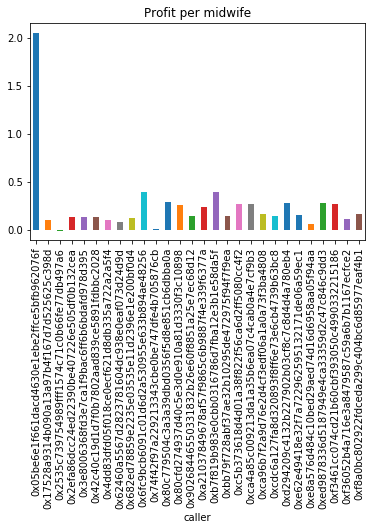

In [43]:
res.groupby(['caller']).profit.sum().plot(kind='bar', title='Profit per midwife')

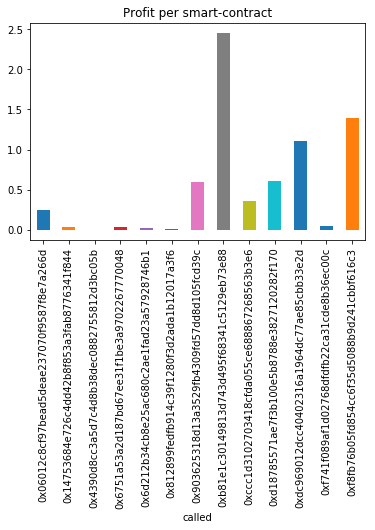

In [44]:
res.groupby(['called']).profit.sum().plot(kind='bar', title='Profit per smart-contract')

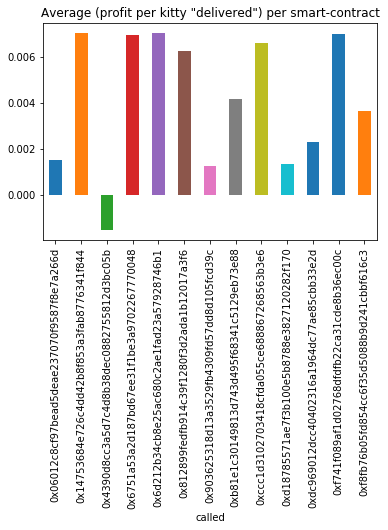

In [45]:
res.groupby(['called']).efficiency.mean().plot(kind='bar', title='Average (profit per kitty "delivered") per smart-contract')